In [136]:
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import copy

from ReadMaestro import maestro
from ReadMaestro import parse_pursuit_trials
paths = [p for p in sys.path if os.path.exists(p)]
print(paths)

from importlib import reload
reload(maestro)
reload(parse_pursuit_trials)

['/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '/home/seth/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages']


<module 'ReadMaestro.parse_pursuit_trials' from '/home/seth/analysis/ReadMaestro/ReadMaestro/parse_pursuit_trials.py'>

In [2]:
#file_path = '/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a/ar220404a.0001'
#with open(file_path, 'rb') as f:
#    data_file = maestro.DataFile.load(f.read(), file_path)

In [3]:
instrument_data = maestro.load_directory('/home/seth/Projects/DynamicCoherencePhysiology/test/20191118b')
instrument = parse_pursuit_trials.pursuitDataObject()
instrument.setName(instrument_data)
print(instrument.name)

instrument.pursuitData(instrument_data,trialIDs=['dPref'], directions=[], speeds=[], coherences=[], perturbations=[]);

instrumentNoise = (np.var(instrument.hvelocities) + np.var(instrument.vvelocities))/2
print(instrumentNoise)

/home/seth/Projects/DynamicCoherencePhysiology/test/20191118b
0.4754257839211303


In [4]:
data = maestro.load_directory('/home/seth/Projects/DynamicCoherencePhysiology/ar/20220404a')

In [137]:
purs = parse_pursuit_trials.pursuitDataObject()
# purs.__init__(purs)
purs.setName(data)
print(purs.name)

purs.pursuitData(data,trialIDs=['initCoh'], directions=[0.0,45.0,90.0,135.0,180.0,225.0,270.0,315.0], speeds=[5.0,10.0,20.0], coherences=[100.0], perturbations=[]);
purs.applyRotationToData()

purs_permute = copy.deepcopy(purs)
purs_permute.permuteSaccades()

purs.setSaccadeVelocitiesToNaN()
purs.scaleVelocities()

purs_permute.setSaccadeVelocitiesToNaN()
purs_permute.scaleVelocities()

/home/seth/Projects/DynamicCoherencePhysiology/ar/2022040


Text(0, 0.5, 'Horizontal velocity (deg/s)')

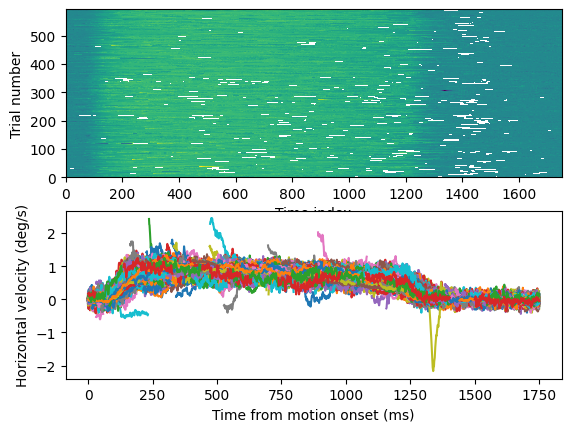

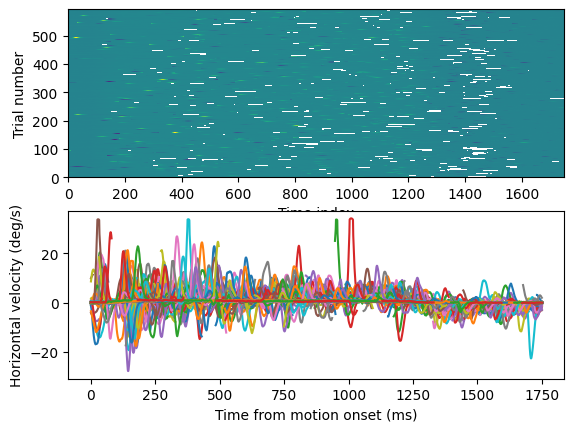

In [6]:
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].pcolor(purs.hvelocities.T);
axes[0].set_ylabel('Trial number')
axes[0].set_xlabel('Time index')

axes[1].plot(purs.eye_t,purs.hvelocities);
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Horizontal velocity (deg/s)')

fig2, axes2 = plt.subplots(nrows=2, ncols=1)
axes2[0].pcolor(purs_permute.hvelocities.T);
axes2[0].set_ylabel('Trial number')
axes2[0].set_xlabel('Time index')

axes2[1].plot(purs_permute.eye_t,purs_permute.hvelocities);
axes2[1].set_xlabel('Time from motion onset (ms)')
axes2[1].set_ylabel('Horizontal velocity (deg/s)')

In [7]:
mu, C = purs.computeMeanCov(purs.hvelocities)

print(np.shape(C))
print(np.shape(mu))

(1751, 1751)
(1751,)


Text(0, 0.5, 'Mean horizontal velocity (deg/s)')

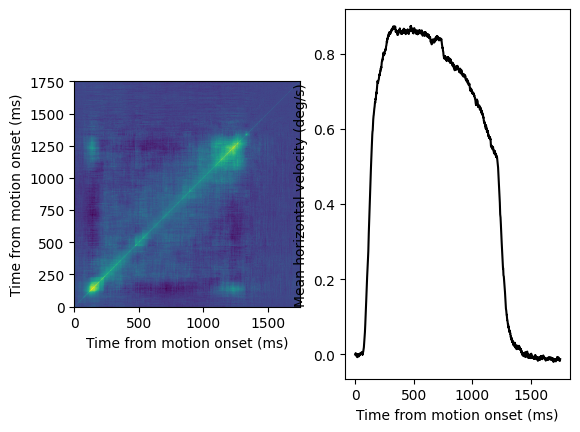

In [8]:

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].pcolor(C);
axes[0].set_aspect('equal', 'box')
axes[0].set_xlabel('Time from motion onset (ms)')
axes[0].set_ylabel('Time from motion onset (ms)')

axes[1].plot(purs.eye_t,mu,'k')
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Mean horizontal velocity (deg/s)')

In [55]:
x = purs.hvelocities[:,-55]
y = np.logical_not(np.isnan(x))
f = x[y]
print(np.mean(purs.speeds))
print(instrumentNoise)

# Gaussian process inference
mu_, C_, C_UnObs, C_ObsObs = purs.conditionalGaussian(mu,np.array(C),f,x_indices=y,obsNoise=instrumentNoise/np.mean(purs.speeds),nearSPD=False)

# Linear interpolation
xinterp = purs.linearInterpolation(x,purs.eye_t)

11.666666666666666
0.4754257839211303


Text(0, 0.5, 'Horizontal velocity - mean (deg/s)')

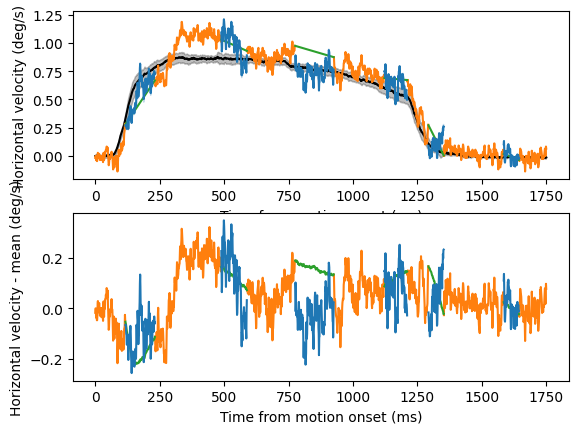

In [57]:
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(purs.eye_t,mu,'k')
lb = mu - np.diag(np.array(C))*1.96
ub = mu + np.diag(np.array(C))*1.96
axes[0].fill_between(purs.eye_t,lb,ub, color='k',alpha=0.25)
axes[0].plot(purs.eye_t,x,'tab:orange')
temp = np.empty_like(mu)
interp = np.empty_like(mu)
temp[y] = np.nan
interp[y] = np.nan
temp[np.logical_not(y)] = mu_
interp[np.logical_not(y)] = xinterp
lb = np.empty_like(mu)
lb[y] = np.nan
lb[np.logical_not(y)] = mu_ - np.diag(C_)*1.96
ub = np.empty_like(mu)
ub[y] = np.nan
ub[np.logical_not(y)] = mu_ + np.diag(C_)*1.96
axes[0].plot(purs.eye_t,interp,'tab:green')
axes[0].plot(purs.eye_t,temp,'tab:blue')
axes[0].fill_between(purs.eye_t,lb,ub, color='tab:blue',alpha=0.25)
axes[0].set_xlabel('Time from motion onset (ms)')
axes[0].set_ylabel('Horizontal velocity (deg/s)')

axes[1].plot(purs.eye_t,x-mu,'tab:orange')
axes[1].plot(purs.eye_t,interp-mu,'tab:green')
axes[1].plot(purs.eye_t,temp-mu,'tab:blue')
axes[1].set_xlabel('Time from motion onset (ms)')
axes[1].set_ylabel('Horizontal velocity - mean (deg/s)')

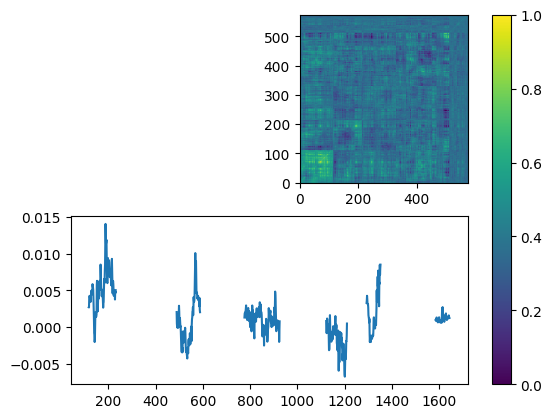

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].pcolor(C_)
axes[0].set_aspect('equal', 'box')
fig.colorbar(plt.cm.ScalarMappable(), ax=axes)
axes[0].set_aspect('equal', 'box')

temp = np.empty_like(mu)
temp[y] = np.nan
temp[np.logical_not(y)] = np.diag(C_)
axes[1].plot(purs.eye_t,temp)
# axes[1].pcolor(C_ObsObs)
# axes[1].set_aspect('equal', 'box')
# axes[2].pcolor(C_UnObs @ np.linalg.inv(C_ObsObs))
# axes[2].set_aspect('equal', 'box')
# fig.colorbar(plt.cm.ScalarMappable(), ax=axes[2])
# axes[3].pcolor(C_)
# axes[3].set_aspect('equal', 'box')

In [110]:
# Test conditionalGaussian
Ntest = 100
Sig = np.ones((Ntest,Ntest))
for i in range(Ntest):
    for j in range(Ntest):
        Sig[i,j] = np.exp( -(i-j)**2/100 )

#Sig = Sig + 0.0005*np.identity(Ntest)

mu_test = np.zeros((Ntest,))
x = np.random.multivariate_normal(mu_test,Sig)
print(x.shape)

t = np.arange(Ntest)
y = np.ones_like(mu_test, dtype=bool)
y[10:20] = False
y[60:80] = False
q = sum(y)
f = x[y]
# muObs = mu_test[y]
# muUn = mu_test[np.logical_not(y)]

# SigUnUn = Sig[0:Ntest-q,0:Ntest-q]
# SigUnObs = Sig[0:Ntest-q,Ntest-q:]
# SigObsObs = Sig[Ntest-q:,Ntest-q:] + 0.0000001*np.identity(q)
# SigObsUn = Sig[Ntest-q:,0:Ntest-q]

# temp = SigUnObs @ np.linalg.inv(SigObsObs)
# mu_ = muUn + temp @ (f-muObs)
mu_, a, b, c = purs.conditionalGaussian(mu_test,Sig,f,x_indices=y,obsNoise=0.0000001)
print(mu_)

(100,)
[ 0.92940591  1.3561624   1.7787464   2.17278185  2.51899298  2.80467273
  3.02395192  3.1770658   3.2689512   3.30753198 -0.49040246 -0.5436128
 -0.63869083 -0.76867504 -0.92201208 -1.08396525 -1.23825083 -1.36861004
 -1.46015138 -1.50043767 -1.48038586 -1.39506383 -1.24440956 -1.03379976
 -0.77430446 -0.48242536 -0.17915131  0.11172847  0.3659606   0.56156334]


In [111]:
# Test linear interpolation
yinterp = np.interp(t[np.logical_not(y)], t[y], x[y])
print(yinterp.shape)

(30,)


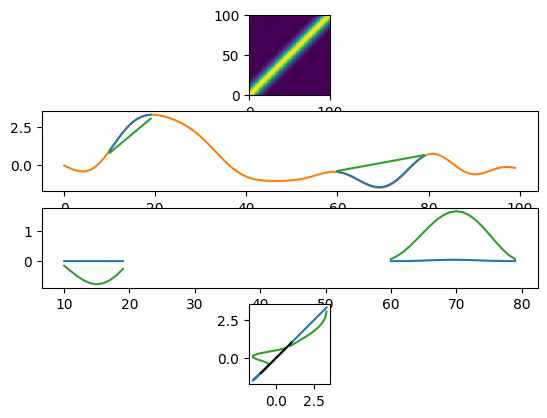

In [115]:
fig, axes = plt.subplots(nrows=4, ncols=1)
axes[0].pcolor(Sig)
axes[0].set_aspect('equal', 'box')
#axes[1].pcolor(SigUnObs)
#axes[1].set_aspect('equal', 'box')
#axes[2].pcolor(SigObsObs)
#xes[2].set_aspect('equal', 'box')
#axes[3].pcolor(temp.T)
axes[1].plot(t,x,'tab:orange')
#axes[1].plot(t[y],f,'+')
temp = np.empty_like(x)
temp[y] = np.nan
temp[np.logical_not(y)] = mu_
axes[1].plot(t,temp,'tab:blue')
axes[2].plot(t,temp-x,'tab:blue')
axes[3].plot(x,temp,'tab:blue')

temp[np.logical_not(y)] = yinterp
axes[1].plot(t,temp,'tab:green')
axes[2].plot(t,temp-x,'tab:green')
axes[3].plot(x,temp,'tab:green')

axes[3].plot([-1,1],[-1,1],'k')
axes[3].set_aspect('equal', 'box')


(-0.4, 0.4)

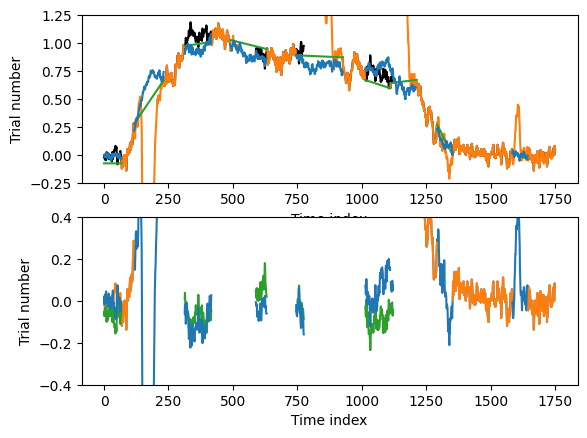

In [60]:
triali = -55
x = purs_permute.hvelocities[:,triali]
xtemp = np.empty_like(x)
y = np.logical_not(np.isnan(x) + np.isnan(purs.hvelocities[:,triali]))
f = x[y]
xtemp[y] = x[y]
xtemp[np.logical_not(y)] = np.nan
mu_, C_, C_UnObs, C_ObsObs = purs.conditionalGaussian(mu,np.array(C),f,x_indices=y,obsNoise=instrumentNoise/np.mean(purs.speeds),nearSPD=False)
xinterp = purs.linearInterpolation(xtemp,purs.eye_t)

temp = np.empty_like(mu)
interp = np.empty_like(mu)
temp[y] = np.nan
interp[y] = np.nan
temp[np.logical_not(y)] = mu_
interp[np.logical_not(y)] = xinterp

fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(purs_permute.eye_t,purs.hvelocities[:,triali],'k')
axes[0].plot(purs_permute.eye_t,purs_permute.hvelocities[:,triali],'tab:orange')
axes[0].plot(purs_permute.eye_t,interp,'tab:green')
axes[0].plot(purs.eye_t,temp,'tab:blue')
axes[0].set_ylabel('Trial number')
axes[0].set_xlabel('Time index')
axes[0].set_ylim(-0.25, 1.25)

axes[1].plot(purs.eye_t,purs_permute.hvelocities[:,triali],purs.hvelocities[:,triali],'tab:orange')
axes[1].plot(purs.eye_t,interp - purs.hvelocities[:,triali],'tab:green')
axes[1].plot(purs.eye_t,temp - purs.hvelocities[:,triali],'tab:blue')
axes[1].set_ylabel('Trial number')
axes[1].set_xlabel('Time index')
axes[1].set_ylim(-0.4, 0.4)

In [138]:
errs, sse_gaussianProcess = purs.measureInferenceErrors(purs_permute,mu=mu,C=C,obsNoise=instrumentNoise/np.mean(purs.speeds))
errs_interp, sse_linearInterp = purs.measureInferenceErrors(purs_permute, inferenceMethod='linearInterpolation')

Axes(0.125,0.53;0.352273x0.35)


<BarContainer object of 25 artists>

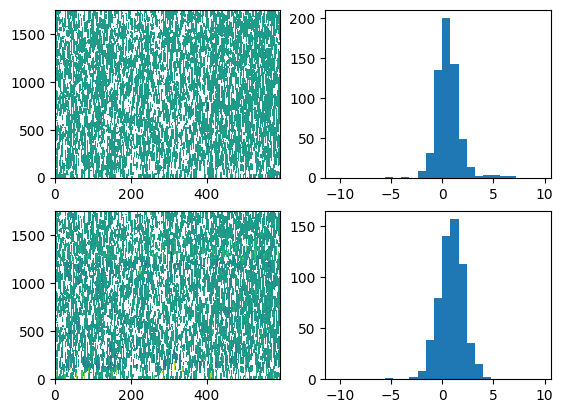

In [139]:
a = np.log(sse_gaussianProcess)
b,c = np.histogram(a[np.logical_not(np.isnan(a))],bins=25,range=(-10,10))

fig, axes = plt.subplots(nrows=2, ncols=2)
print(axes[0,0])
axes[0,0].pcolor(errs)
axes[0,1].bar(c[:-1], b, width=np.diff(c))

a = np.log(sse_linearInterp)
b,c = np.histogram(a[np.logical_not(np.isnan(a))],bins=25,range=(-10,10))
axes[1,0].pcolor(errs_interp)
axes[1,1].bar(c[:-1], b, width=np.diff(c))

Text(0.5, 0, 'Gaussian process log(sse)')

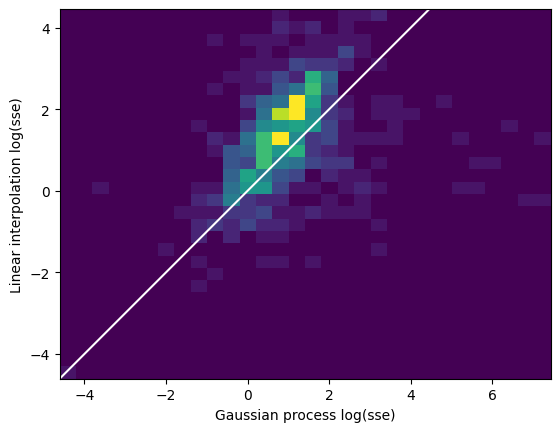

In [140]:

fig, axes = plt.subplots(nrows=1,ncols=1)
axes.hist2d(np.log(sse_gaussianProcess),np.log(sse_linearInterp),bins=30)
axes.plot([-10,10],[-10,10],'w')
axes.set_aspect('equal', 'box')
axes.set_ylabel('Linear interpolation log(sse)')
axes.set_xlabel('Gaussian process log(sse)')